# Informações gerais

Esse notebook objetiva comparar a performance de diferentes algoritmos de alocação e roteamento em comparação com o RSA e SAR.

Todas as simulações estão na Carga de 300 Erlangs

## Importando todos os pacotes e funções necessárias

In [1]:
# Printa a versão do Python
import sys
print(f"Versão do Python: {sys.version}")

Versão do Python: 3.11.7 (tags/v3.11.7:fa7a6f2, Dec  4 2023, 19:24:49) [MSC v.1937 64 bit (AMD64)]


In [2]:
# Importa as bibliotecas
import os
import pickle

import numpy as np
import pandas as pd

import torch as th

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

%matplotlib inline

In [3]:
from Enviroment.Settings import *
from Enviroment.Manager import Enviroment

In [4]:
from stable_baselines3 import PPO

In [5]:
def run_test(env, num_sim=10, main_seed=42, type_model="RSA", data=None):
    """ Realiza a simulação do modelo em um ambiente de simulação e retorna as probabilidades de bloqueio e as recompensas médias.

    Args:
        env (Enviroment): Ambiente de simulação.
        model (Model): Modelo a ser testado.
        num_sim (int): Número de simulações a serem realizadas.

    Returns:
        pbs (np.array): Probabilidades de bloqueio.
        reward (np.array): Recompensas médias.
    """

    number_of_nodes = env._number_of_nodes

    # Verifica se model é uma string com o nome do modelo
    if type_model not in ['RSA', 'SAR', 'GA', 'PPO']: 
            raise ValueError("Model must be 'RSA', 'SAR', a trained model from Stable Baselines 3 or a numpy array with the size equal to the number of nodes squared.")

    if type_model == 'RSA':
        print("Modelo: RSA")
    elif type_model == 'SAR':
        print("Modelo: SAR")
    elif type_model == 'GA':
        print("Modelo: GA")
    elif type_model == 'PPO':
        print("Modelo: PPO")

    # Reseta a seed para garantir a reprodutibilidade dos resultados
    np.random.seed(main_seed)

    # Gera uma seed para cada simulação
    seeds = np.random.randint(0, 100_000, num_sim, dtype=int)

    # Cria um array para armazenar as probabilidades de bloqueio e as recompensas de cada simulação
    pbs = np.zeros(num_sim)
    rewards = np.zeros(num_sim)

    RSA_SAR_count = [0, 0]

    # Executa as simulações
    for i, seed in enumerate(seeds):

        print(f"Executando simulação {i+1} de {num_sim} com seed {seed}.")

        # Reseta o ambiente para garantir que ele esteja no estado inicial usando a seed
        state, info = env.reset(int(seed))

        # Executa a simulação
        while True:

            if type_model == 'RSA':
                alg_heuristic = 0
            elif type_model == 'SAR':
                alg_heuristic = 1
            elif type_model == 'GA':
                alg_heuristic = data[state[1] + state[0] * 14]
            elif type_model == 'PPO':
                alg_heuristic = data.predict(observation=state, deterministic=True)[0]

            RSA_SAR_count[alg_heuristic] += 1

            state, _, done, trunk, info = env.step(alg_heuristic)

            if (done or trunk) and rewards[i] == 0:
                rewards[i] = env._reward_episode
                break

        pbs[i] = info['total_number_of_blocks'] / info['last_request']

        print(f"Blocking Probability: {pbs[i]} | Reward: {rewards[i]} | Req: {info['last_request']}")

    print(f"\nBlocking Probability: {np.mean(pbs)} | Min: {np.min(pbs)} | Max: {np.max(pbs)} | +- {np.std(pbs)}")
    print(f"Reward: {np.mean(rewards)} | Min: {np.min(rewards)} | Max: {np.max(rewards)} | +- {np.std(rewards)}")
    print(f"RSA count: {RSA_SAR_count[0]} ({RSA_SAR_count[0]/(RSA_SAR_count[0]+RSA_SAR_count[1]):.2%}) | SAR count: {RSA_SAR_count[1]} ({RSA_SAR_count[1]/(RSA_SAR_count[0]+RSA_SAR_count[1]):.2%})")

    return {
        'pbs': pbs,
        'rewards': rewards,
        'RSA_SAR_count': RSA_SAR_count
    }

In [8]:
def include_models(models_results):
    
    # Cria um boxplot com as probabilidades de bloqueio no gráfico da esquerda e um boxplot com as recompensas no gráfico da direita para cada modelo
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Cria a lista com o nome dos modelos
    data_name = []
    # Cria a lista com as probabilidades de bloqueio
    data_PB = []
    # Cria a lista com as recompensas
    data_rewards = []

    data_RSA_SAR_count = []

    for model_name, model_data in models_results.items():

        data_name.append(model_name)

        data_PB.append(model_data["pbs"])

        data_rewards.append(model_data["rewards"])

        data_RSA_SAR_count.append(model_data["RSA_SAR_count"])

    # Boxplot das probabilidades de bloqueio em escala logarítmica
    sns.boxplot(data=data_PB, ax=axs[0])
    axs[0].set_yscale("log")

    axs[0].set_title("Blocking Probability")

    axs[0].xaxis.set_major_locator(ticker.FixedLocator(range(len(data_name))))  # Set fixed locations for ticks
    axs[0].set_xticklabels(data_name)

    axs[0].set_ylabel("Blocking Probability")
    axs[0].grid(axis="y", which="both", linestyle="--", linewidth=0.7)


    sns.boxplot(data=data_rewards, ax=axs[1])

    axs[1].set_title("Rewards")

    axs[1].xaxis.set_major_locator(ticker.FixedLocator(range(len(data_name))))  # Set fixed locations for ticks
    axs[1].set_xticklabels(data_name)
    axs[1].set_ylabel("Rewards")

    axs[1].grid(axis="y", which="both", linestyle="--", linewidth=0.7)

    # Gráfico com a contagem de RSA e SAR
    data_RSA_SAR_count = np.array(data_RSA_SAR_count)

    axs[2].bar(data_name, data_RSA_SAR_count[:, 0], label="RSA")
    axs[2].bar(data_name, data_RSA_SAR_count[:, 1], bottom=data_RSA_SAR_count[:, 0], label="SAR")

    axs[2].set_title("RSA and SAR count")

    axs[2].set_ylabel("Count")
    axs[2].legend()
    axs[2].grid(axis="y", which="both", linestyle="--", linewidth=0.7)

    


    # Se há mais que 4 modelos a serem comparados, rotaciona os labels do eixo x
    if len(data_name) > 4:
        for ax in axs:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')

    plt.show()

# Avaliando os modelos

In [6]:
# Avaliando a PB do modelo treinado
enviroment_type_test = {
    "Observation": "OD",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

In [7]:
results_models_240e = {}

In [9]:
NETWORK_LOADS = np.linspace(240, 300, 7, dtype=int)

## R-SA

In [11]:
RSA_DATA_LOADS = []

for network_load in NETWORK_LOADS:
    print(f"Network Load: {network_load}")

    # Cria o ambiente de simulação
    env = Enviroment(
        network_load=network_load,
        k_routes=K_ROUTES,
        number_of_slots=NUMBER_OF_SLOTS,
        enviroment_type=enviroment_type_test,
        data_folder="CURVE_LOAD",
    )

    data = run_test(env, num_sim=1, main_seed=123, type_model='RSA')

    RSA_DATA_LOADS.append(data)

Network Load: 240
Modelo: RSA
Executando simulação 1 de 1 com seed 15725.
Blocking Probability: 0.00099 | Reward: 998020.0 | Req: 1000000

Blocking Probability: 0.00099 | Min: 0.00099 | Max: 0.00099 | +- 0.0
Reward: 998020.0 | Min: 998020.0 | Max: 998020.0 | +- 0.0
RSA count: 1000000 (100.00%) | SAR count: 0 (0.00%)
Network Load: 250
Modelo: RSA
Executando simulação 1 de 1 com seed 15725.
Blocking Probability: 0.001812 | Reward: 996376.0 | Req: 1000000

Blocking Probability: 0.001812 | Min: 0.001812 | Max: 0.001812 | +- 0.0
Reward: 996376.0 | Min: 996376.0 | Max: 996376.0 | +- 0.0
RSA count: 1000000 (100.00%) | SAR count: 0 (0.00%)
Network Load: 260
Modelo: RSA
Executando simulação 1 de 1 com seed 15725.
Blocking Probability: 0.003127 | Reward: 993746.0 | Req: 1000000

Blocking Probability: 0.003127 | Min: 0.003127 | Max: 0.003127 | +- 0.0
Reward: 993746.0 | Min: 993746.0 | Max: 993746.0 | +- 0.0
RSA count: 1000000 (100.00%) | SAR count: 0 (0.00%)
Network Load: 270
Modelo: RSA
Executan

## SAR

In [13]:
SAR_DATA_LOADS = []

for network_load in NETWORK_LOADS:
    print(f"Network Load: {network_load}")

    # Cria o ambiente de simulação
    env = Enviroment(
        network_load=network_load,
        k_routes=K_ROUTES,
        number_of_slots=NUMBER_OF_SLOTS,
        enviroment_type=enviroment_type_test,
        data_folder="CURVE_LOAD",
    )

    data = run_test(env, num_sim=1, main_seed=123, type_model='SAR')

    SAR_DATA_LOADS.append(data)

Network Load: 240
Modelo: SAR
Executando simulação 1 de 1 com seed 15725.
Blocking Probability: 0.000189 | Reward: 999622.0 | Req: 1000000

Blocking Probability: 0.000189 | Min: 0.000189 | Max: 0.000189 | +- 0.0
Reward: 999622.0 | Min: 999622.0 | Max: 999622.0 | +- 0.0
RSA count: 0 (0.00%) | SAR count: 1000000 (100.00%)
Network Load: 250
Modelo: SAR
Executando simulação 1 de 1 com seed 15725.
Blocking Probability: 0.000511 | Reward: 998978.0 | Req: 1000000

Blocking Probability: 0.000511 | Min: 0.000511 | Max: 0.000511 | +- 0.0
Reward: 998978.0 | Min: 998978.0 | Max: 998978.0 | +- 0.0
RSA count: 0 (0.00%) | SAR count: 1000000 (100.00%)
Network Load: 260
Modelo: SAR
Executando simulação 1 de 1 com seed 15725.
Blocking Probability: 0.001225 | Reward: 997550.0 | Req: 1000000

Blocking Probability: 0.001225 | Min: 0.001225 | Max: 0.001225 | +- 0.0
Reward: 997550.0 | Min: 997550.0 | Max: 997550.0 | +- 0.0
RSA count: 0 (0.00%) | SAR count: 1000000 (100.00%)
Network Load: 270
Modelo: SAR
Exec

## GA MAth

In [ ]:
GA_MATH_DATA_LOADS = []

chromossome_solution = np.array([0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,])

for network_load in NETWORK_LOADS:
    print(f"Network Load: {network_load}")

    # Cria o ambiente de simulação
    env = Enviroment(
        network_load=network_load,
        k_routes=K_ROUTES,
        number_of_slots=NUMBER_OF_SLOTS,
        enviroment_type=enviroment_type_test,
        data_folder="CURVE_LOAD",
    )

    data = run_test(env, num_sim=1, main_seed=123, type_model='GA', data=chromossome_solution)

    GA_MATH_DATA_LOADS.append(data)

Network Load: 240
Executando a avaliação do GA
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.000158 | Reward: 999684.0 | Req: 1000000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.000165 | Reward: 999670.0 | Req: 1000000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.000179 | Reward: 999642.0 | Req: 1000000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.000175 | Reward: 999650.0 | Req: 1000000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.000169 | Reward: 999662.0 | Req: 1000000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.000189 | Reward: 999622.0 | Req: 1000000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.000187 | Reward: 999626.0 | Req: 1000000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.000167 | Reward: 999666.0 | Req: 1000000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.0001

## Modelo V11

In [42]:
enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

MODEL11_DATA_LOADS = []

for network_load in NETWORK_LOADS:
    print(f"Network Load: {network_load}")

    # Cria o ambiente de simulação
    env = Enviroment(
        network_load=network_load,
        k_routes=K_ROUTES,
        number_of_slots=NUMBER_OF_SLOTS,
        enviroment_type=enviroment_type_models,
        data_folder="CURVE_LOAD",
    )

    model_v11 =PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_PPO_40kReqs_300_v11_001\\training\\best_model\\best_model.zip", env=env)

    data = run_test(env, model_v11, num_sim=1, main_seed=123)

    MODEL11_DATA_LOADS.append(data)


Network Load: 240
Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.000153 | Reward: 999694.0 | Req: 1000000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.000126 | Reward: 999748.0 | Req: 1000000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.000151 | Reward: 999698.0 | Req: 1000000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.000156 | Reward: 999688.0 | Req: 1000000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.000145 | Reward: 999710.0 | Req: 1000000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.000135 | Reward: 999730.0 | Req: 1000000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.000171 | Reward: 999658.0 | Req: 1000000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.000114 | Reward: 999772.0 | Req: 1000000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.

KeyboardInterrupt: 

## Gráfico

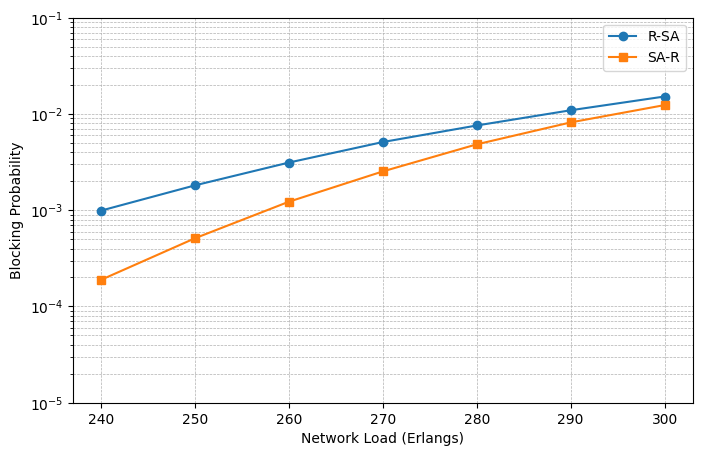

In [14]:
# Cria um gráfico com a probabilidade de bloqueio para cada carga de rede simulada. O valor das probabilidades de bloqueio é a média de 15 simulações. Devem ser apresentados a marge de erro de 1 desvio padrão.

fig, ax = plt.subplots(figsize=(8, 5))

ax.semilogy(NETWORK_LOADS, [np.mean(data['pbs']) for data in RSA_DATA_LOADS], label="R-SA", marker="o")
ax.fill_between(NETWORK_LOADS, [np.mean(data['pbs']) - np.std(data['pbs']) for data in RSA_DATA_LOADS], [np.mean(data['pbs']) + np.std(data['pbs']) for data in RSA_DATA_LOADS], alpha=0.3)

ax.semilogy(NETWORK_LOADS, [np.mean(data['pbs']) for data in SAR_DATA_LOADS], label="SA-R", marker="s")
ax.fill_between(NETWORK_LOADS, [np.mean(data['pbs']) - np.std(data['pbs']) for data in SAR_DATA_LOADS], [np.mean(data['pbs']) + np.std(data['pbs']) for data in SAR_DATA_LOADS], alpha=0.3)

# ax.semilogy(NETWORK_LOADS, [np.mean(data['pbs']) for data in GA_MATH_DATA_LOADS], label="GA", marker="x")
# ax.fill_between(NETWORK_LOADS, [np.mean(data['pbs']) - np.std(data['pbs']) for data in GA_MATH_DATA_LOADS], [np.mean(data['pbs']) + np.std(data['pbs']) for data in GA_MATH_DATA_LOADS], alpha=0.3)

# ax.semilogy(NETWORK_LOADS, [np.mean(data['pbs']) for data in GA_HERMANO_DATA_LOADS], label="GA Hermano", marker="d")
# ax.fill_between(NETWORK_LOADS, [np.mean(data['pbs']) - np.std(data['pbs']) for data in GA_HERMANO_DATA_LOADS], [np.mean(data['pbs']) + np.std(data['pbs']) for data in GA_HERMANO_DATA_LOADS], alpha=0.3)

# ax.semilogy([240, 250, 260, 270], [np.mean(data['pbs']) for data in MODEL11_DATA_LOADS], label="PPO v11", marker="^")
# ax.fill_between([240, 250, 260, 270], [np.mean(data['pbs']) - np.std(data['pbs']) for data in MODEL11_DATA_LOADS], [np.mean(data['pbs']) + np.std(data['pbs']) for data in MODEL11_DATA_LOADS], alpha=0.3)


# Define o limite do eixo y
ax.set_ylim(1e-5, 1e-1)

#ax.set_title("Blocking Probability x Network Load")
ax.set_xlabel("Network Load (Erlangs)")
ax.set_ylabel("Blocking Probability")
ax.grid(axis="both", which="both", linestyle="--", linewidth=0.5)
ax.legend()

plt.show()

# Boxplot em carga de 260 Erlangs

In [57]:
boxplot_data_240e = {
}


In [58]:

# Cria o ambiente de simulação
env = Enviroment(
    network_load=240,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_test,
    data_folder="Evaluation_RSA_240e",
)

boxplot_data_240e['RSA'] = run_test(env, 'RSA', num_sim=30, main_seed=123)

Executando a avaliação do RSA
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.00099 | Reward: 998020.0 | Req: 1000000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.000994 | Reward: 998012.0 | Req: 1000000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.000955 | Reward: 998090.0 | Req: 1000000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.000935 | Reward: 998130.0 | Req: 1000000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.001038 | Reward: 997924.0 | Req: 1000000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.000965 | Reward: 998070.0 | Req: 1000000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.001033 | Reward: 997934.0 | Req: 1000000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.000951 | Reward: 998098.0 | Req: 1000000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.00097 | Reward: 998060

In [59]:
# Cria o ambiente de simulação
env = Enviroment(
    network_load=240,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_test,
    data_folder="Evaluation_RSA_240e",
)

boxplot_data_240e['SAR'] = run_test(env, 'SAR', num_sim=30, main_seed=123)

Executando a avaliação do SAR
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.000189 | Reward: 999622.0 | Req: 1000000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.000149 | Reward: 999702.0 | Req: 1000000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.000169 | Reward: 999662.0 | Req: 1000000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.000207 | Reward: 999586.0 | Req: 1000000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.000152 | Reward: 999696.0 | Req: 1000000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.000157 | Reward: 999686.0 | Req: 1000000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.00022 | Reward: 999560.0 | Req: 1000000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.000158 | Reward: 999684.0 | Req: 1000000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.00014 | Reward: 999720

In [61]:
chromossome_solution = np.array([0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,])

# Cria o ambiente de simulação
env = Enviroment(
    network_load=240,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_test,
    data_folder="Evaluation_GA_300e",
)

boxplot_data_240e['HRSA'] = run_test(env, chromossome_solution, num_sim=30, main_seed=123)

Executando a avaliação do GA
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.000158 | Reward: 999684.0 | Req: 1000000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.000165 | Reward: 999670.0 | Req: 1000000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.000179 | Reward: 999642.0 | Req: 1000000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.000175 | Reward: 999650.0 | Req: 1000000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.000169 | Reward: 999662.0 | Req: 1000000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.000189 | Reward: 999622.0 | Req: 1000000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.000187 | Reward: 999626.0 | Req: 1000000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.000167 | Reward: 999666.0 | Req: 1000000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.000153 | Reward: 99969

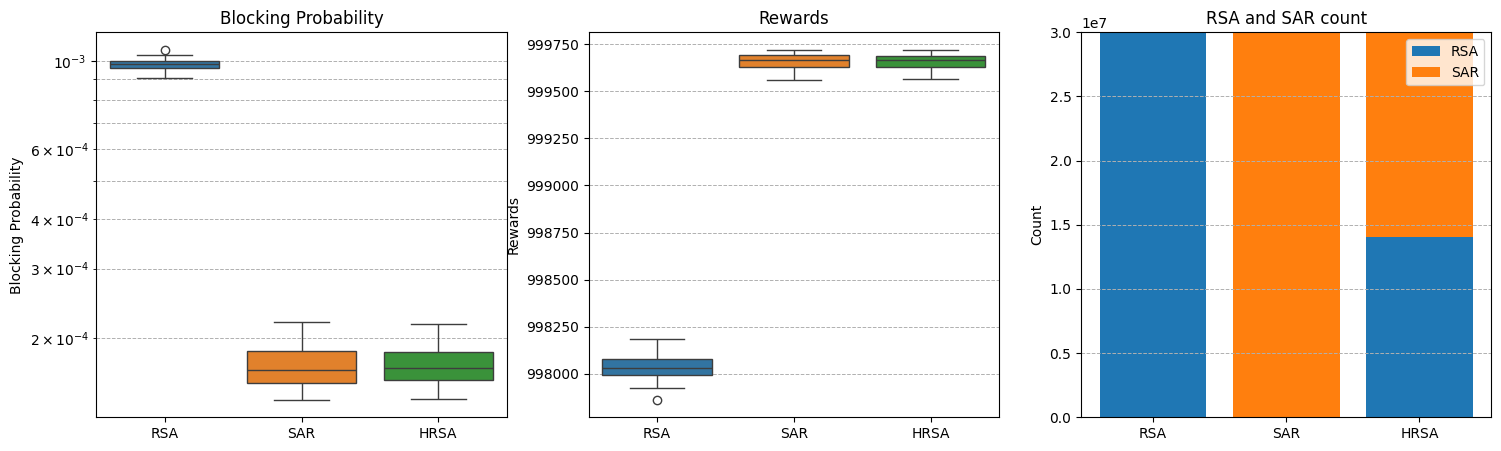

In [62]:
include_models(boxplot_data_240e)